<a href="https://colab.research.google.com/github/adalbertii/modele-NLP/blob/main/---NLP_fake_news_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Model - identyfikacji fake news**

  
                                                                 
=================================================================

Total params: 1 168 769 (4.46 MB)

Trainable params: 168 769 (659.25 KB)

Non-trainable params: 1 000 000 (3.81 MB)

-------------------------------------------------------------------------------

**Wykorzystanie wytrenowanego modelu Embedding**: "glove.twitter.27B.100d"


In [5]:
import datetime

x = datetime.datetime.now()
print(x)

2024-02-22 07:28:57.247849


In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/dane/fake_true_news'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/dane/fake_true_news/Fake.csv
/content/drive/MyDrive/dane/fake_true_news/True.csv


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [4]:
true = pd.read_csv("/content/drive/MyDrive/dane/fake_true_news/True.csv")
false = pd.read_csv("/content/drive/MyDrive/dane/fake_true_news/Fake.csv")

In [6]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [8]:
true['category'] = 1
false['category'] = 0

In [9]:
true.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [10]:
true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     21417 non-null  object
 1   text      21417 non-null  object
 2   subject   21417 non-null  object
 3   date      21417 non-null  object
 4   category  21417 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 836.7+ KB


In [11]:
false.head()

,title,text,subject,date,category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [12]:
false.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     23481 non-null  object
 1   text      23481 non-null  object
 2   subject   23481 non-null  object
 3   date      23481 non-null  object
 4   category  23481 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 917.4+ KB


In [13]:
#połaczeniu obydwu zbiorów (dla celów analiz DataSet)
df = pd.concat([true,false])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44898 non-null  object
 1   text      44898 non-null  object
 2   subject   44898 non-null  object
 3   date      44898 non-null  object
 4   category  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


<Axes: xlabel='category', ylabel='count'>

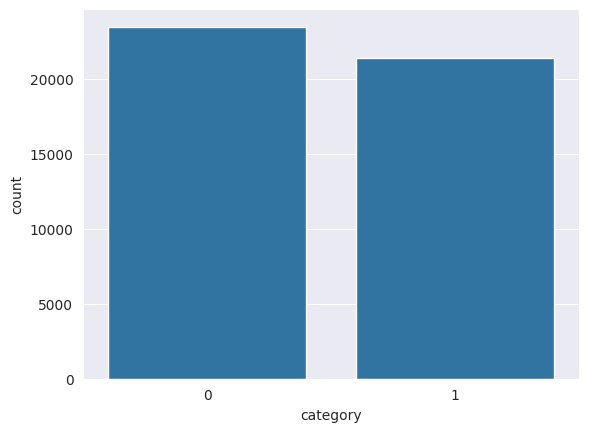

In [15]:
sns.set_style("darkgrid")

sns.countplot(df, x="category")

In [16]:
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [17]:
# sprawdzenie braków danych
df.isna().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [18]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'Government News'),
 Text(5, 0, 'left-news'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

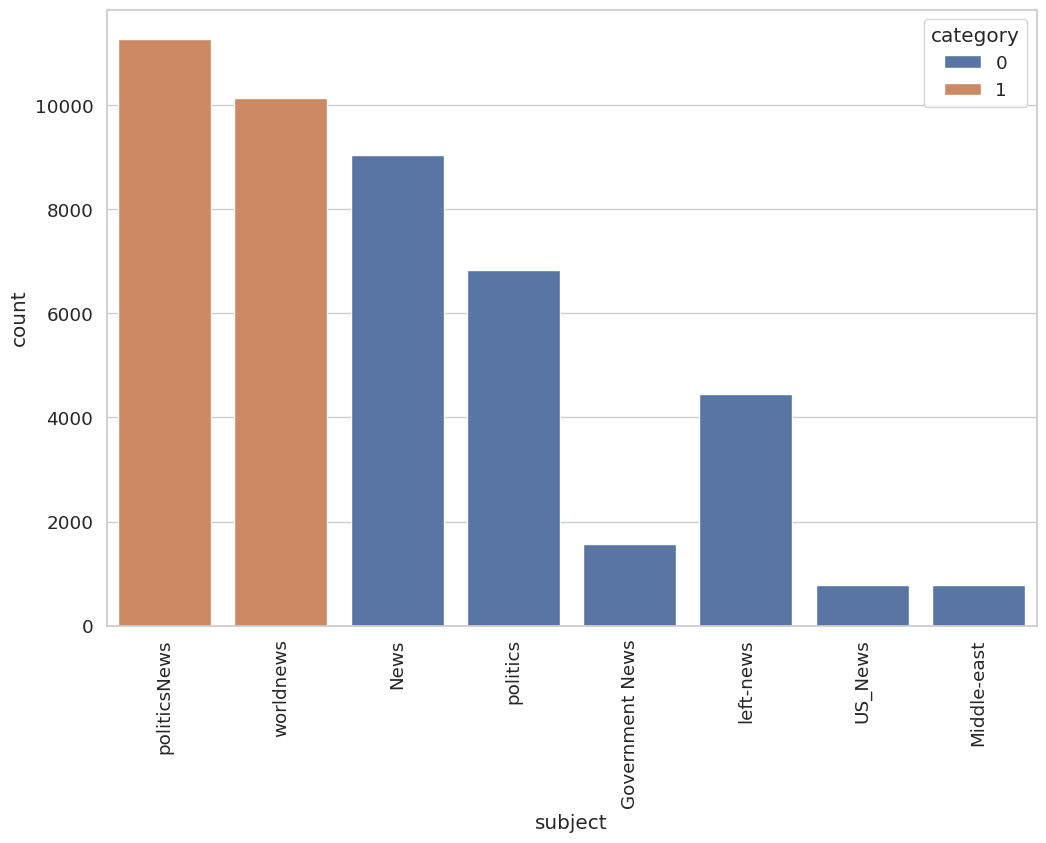

In [19]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "category" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

In [20]:
# df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

In [21]:
df.head()

,text,category
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


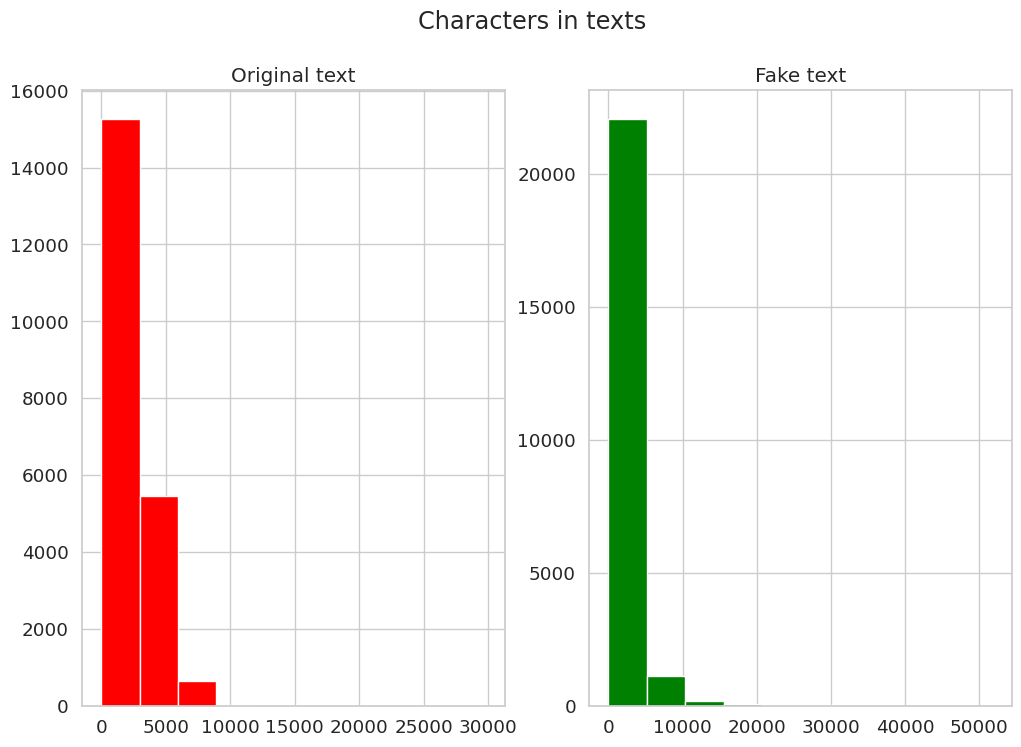

In [22]:
# rozkład liczb znaków w tekstach prawdziwych oraz fake-ach
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=df[df['category']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Original text')

text_len=df[df['category']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')

fig.suptitle('Characters in texts')
plt.show()

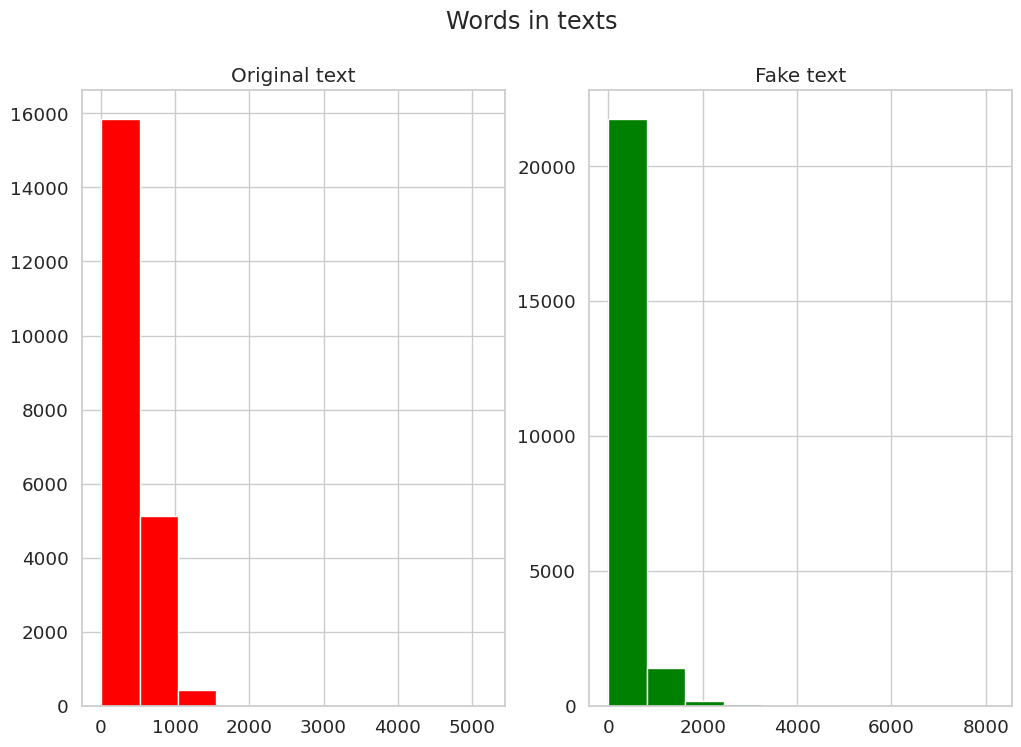

In [ ]:
# rozkład liczby wyrazów  w tekstach prawdziwych oraz w fake-ach
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=df[df['category']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Original text')

text_len=df[df['category']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')

fig.suptitle('Words in texts')
plt.show()

In [24]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words


In [25]:
corpus = get_corpus(df.text)
corpus[:10]

['WASHINGTON',
 '(Reuters)',
 '-',
 'The',
 'head',
 'of',
 'a',
 'conservative',
 'Republican',
 'faction']

In [26]:
# budowa słownika słów z ich liczebnościaą
from collections import Counter
dictionary_with_counter = Counter(corpus)

In [ ]:
dictionary_with_counter

In [34]:
# słownik majczęściej wystepujaych wyrazów
from collections import Counter

counter = Counter(corpus)
most_common = counter.most_common(10) # 10 wnajczęstrzych wyrazów
most_common = dict(most_common)
most_common

{'the': 905825,
 'to': 529815,
 'of': 437532,
 'and': 392470,
 'a': 390084,
 'in': 322378,
 'that': 220928,
 'on': 181758,
 's': 172259,
 'for': 166256}

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_text_ngrams(corpus, n, g):

    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)

    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    return words_freq[:n]

<Axes: >

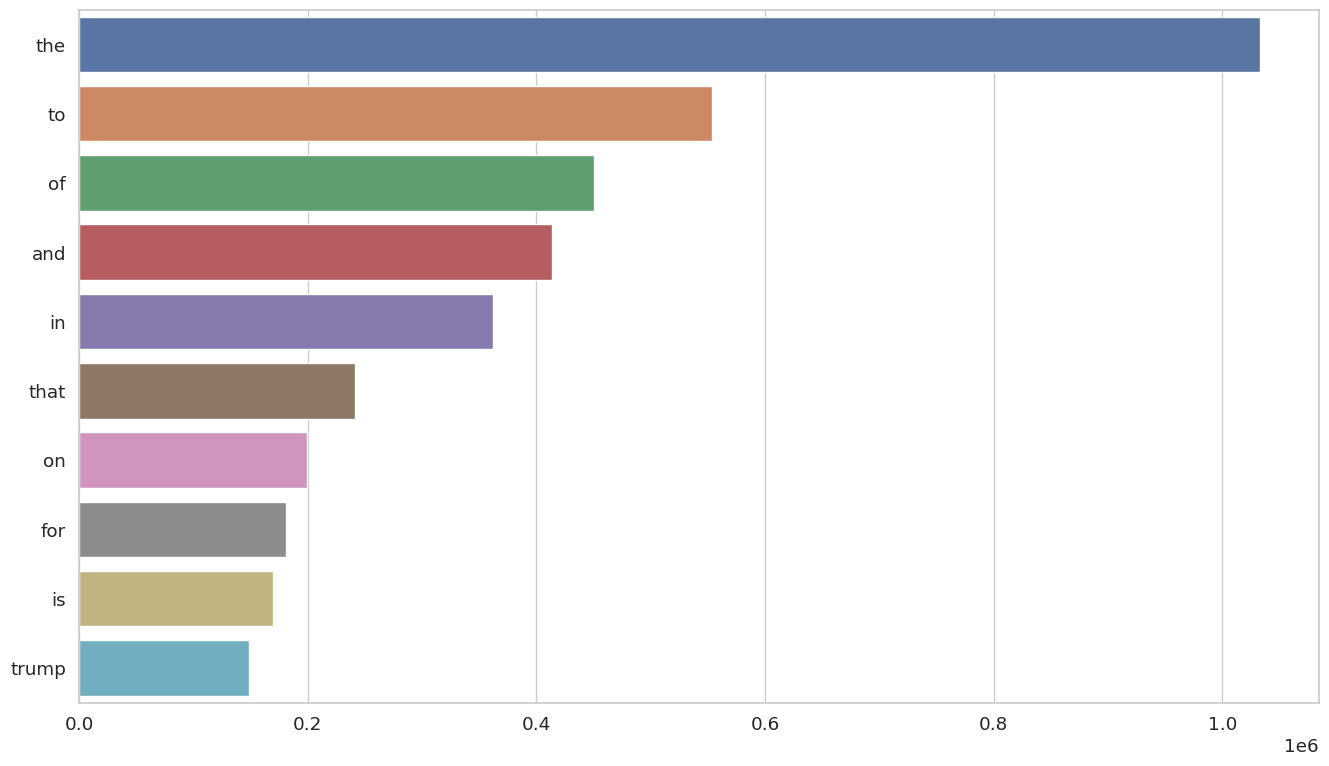

In [ ]:
#analiza unigramów

plt.figure(figsize = (16,9))

most_common_uni = get_top_text_ngrams(df.text,10,1)

most_common_uni = dict(most_common_uni)

sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

<Axes: >

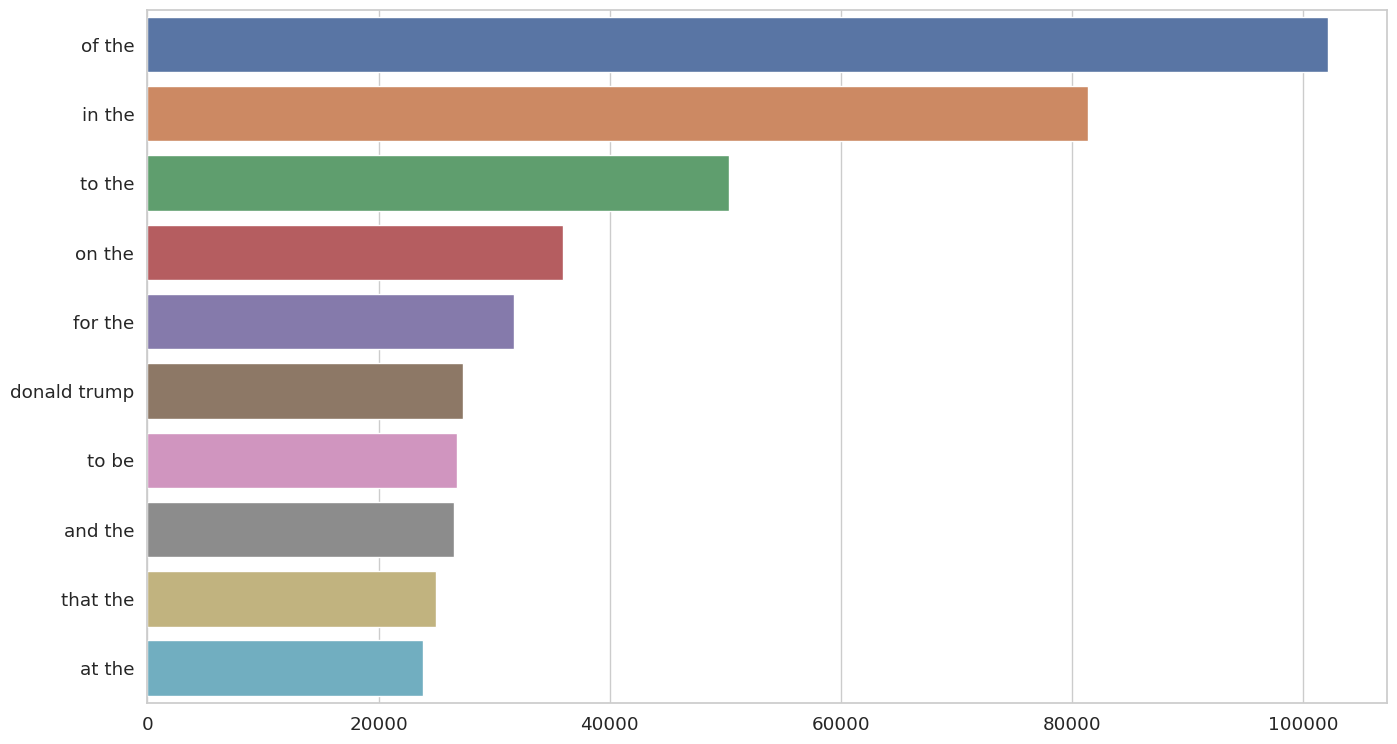

In [ ]:
#analiza bigramów

plt.figure(figsize = (16,9))

most_common_bi = get_top_text_ngrams(df.text,10,2)

most_common_bi = dict(most_common_bi)

sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

<Axes: >

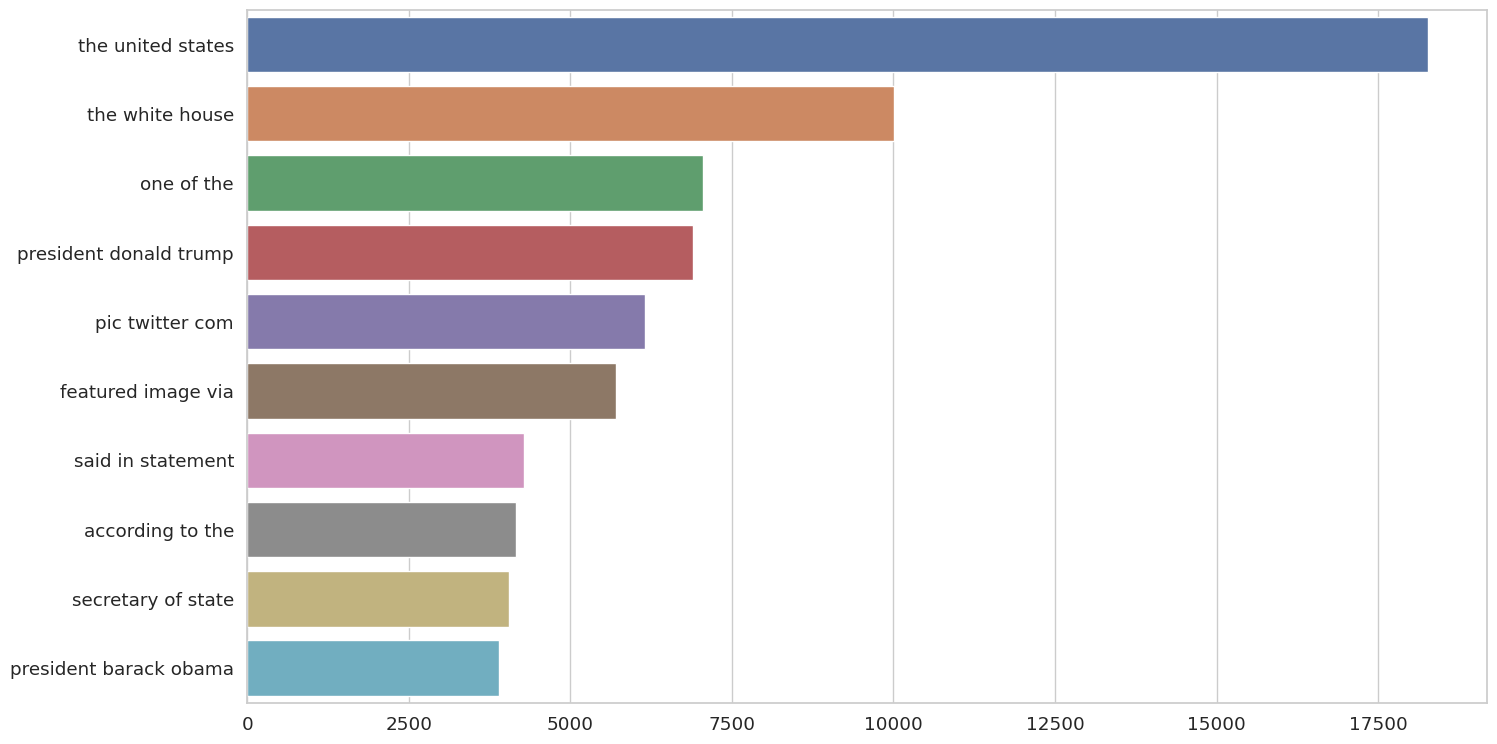

In [ ]:
#analiza trigramów

plt.figure(figsize = (16,9))

most_common_tri = get_top_text_ngrams(df.text,10,3)

most_common_tri = dict(most_common_tri)

sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

In [35]:
#podział danych na date treningowe i testowe

x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)

In [36]:
max_features = 10000 # liczba wyrazów w korpusie (słowniku)
maxlen = 300

In [37]:
# Tokenizacja tekstu -> zastępowanie każdego słowa liczbą
# Mapowanie oryginalnego słowa na liczbę jest zachowane we właściwości word_index tokenizera.
#
# Tokenizer stosuje podstawowe przetwarzanie, takie jak zmiana na małe litery.

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)


In [38]:
# tokenizer dla danych treningowych
tokenized_train = tokenizer.texts_to_sequences(x_train)

# Ustawiamy wszystkie wiadomościna długości  do 300,
# dodawajmy dopełnienie do wiadomości zawierających mniej niż 300 słów i obcinajmy długie.

x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [39]:
# tokenizer dla danych testowych
tokenized_test = tokenizer.texts_to_sequences(x_test)

# Ustawiamy wszystkie wiadomościna długości  do 300,
# dodawajmy dopełnienie do wiadomości zawierających mniej niż 300 słów i obcinajmy długie.

X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [40]:
# ścieżka do  pre-training słownika poddanego procesowi Embedding
EMBEDDING_FILE = '/content/drive/MyDrive/dane/glove-twitter/glove.twitter.27B.100d.txt'

In [41]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


In [47]:
# słownik {wyraz : tablica współczynników embedding}
# około 1 minuty

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [51]:
arr = embeddings_index.values()

In [ ]:
result = tuple(map(tuple, arr))

In [48]:
#all_embs = np.stack(embeddings_index.values())

all_embs = np.stack(result)
emb_mean,emb_std = all_embs.mean(), all_embs.std()

embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

TypeError: arrays to stack must be passed as a "sequence" type such as list or tuple.

In [ ]:
batch_size = 256
epochs = 7
embed_size = 100

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

# Zmniejszenie tempa uczenia się, gdy metryka przestaje się poprawiać.
# Modele często korzystają ze zmniejszenia tempa uczenia się o współczynnik
# od 2 do 10 razy, gdy nauka staje w miejscu.
# To wywołanie zwrotne monitoruje ilośćwielkość i jeśli nie zaobserwowano poprawy krok uczenia jest zmniejszany.

In [ ]:
#definicja sieci neuronowej
model = Sequential()

# warstwa Embedding - NIE podlega procesowi uczenia
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))

# LSTM - Long Short-Term Memory
# jest rekurencyjną siecią neuronową, której celem jest rozwiązanie problemu znikającego gradientu występującego w tradycyjnych sieciach RNN.
# Jego względna niewrażliwość na długość przerwy jest jego przewagą nad innymi RNN, ukrytymi modelami Markowa i innymi metodami uczenia sekwencji.

model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 lstm_4 (LSTM)               (None, 300, 128)          117248    
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1168769 (4.46 MB)
Trainable params: 168769 (659.25 KB)
Non-trainable params: 1000000 (3.81 MB)
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
132/132 [==============================] - 243s 2s/step - loss: 0.2203 - accuracy: 0.9112 - val_loss: 0.1878 - val_accuracy: 0.9279 - lr: 0.0100
Epoch 2/10
132/132 [==============================] - 236s 2s/step - loss: 0.0814 - accuracy: 0.9713 - val_loss: 0.0526 - val_accuracy: 0.9833 - lr: 0.0100
Epoch 3/10
132/132 [==============================] - 236s 2s/step - loss: 0.0535 - accuracy: 0.9811 - val_loss: 0.0372 - val_accuracy: 0.9865 - lr: 0.0100
Epoch 4/10
132/132 [==============================] - 236s 2s/step - loss: 0.0352 - accuracy: 0.9879 - val_loss: 0.0352 - val_accuracy: 0.9872 - lr: 0.0100
Epoch 5/10
132/132 [==============================] - 236s 2s/step - loss: 0.0402 - accuracy: 0.9861 - val_loss: 0.0218 - val_accuracy: 0.9921 - lr: 0.0100
Epoch 6/10
132/132 [==============================] - 237s 2s/step - loss: 0.0226 - accuracy: 0.9923 - val_loss: 0.0208 - val_accuracy: 0.9933 - lr: 0.0100
Epoch 7/10
132/132 [==============================] - 238s 2s/st

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 159s 151ms/step - loss: 0.0072 - accuracy: 0.9977
Accuracy of the model on Training Data is -  99.76539015769958 %
351/351 [==============================] - 53s 150ms/step - loss: 0.0208 - accuracy: 0.9936
Accuracy of the model on Testing Data is -  99.35857653617859 %


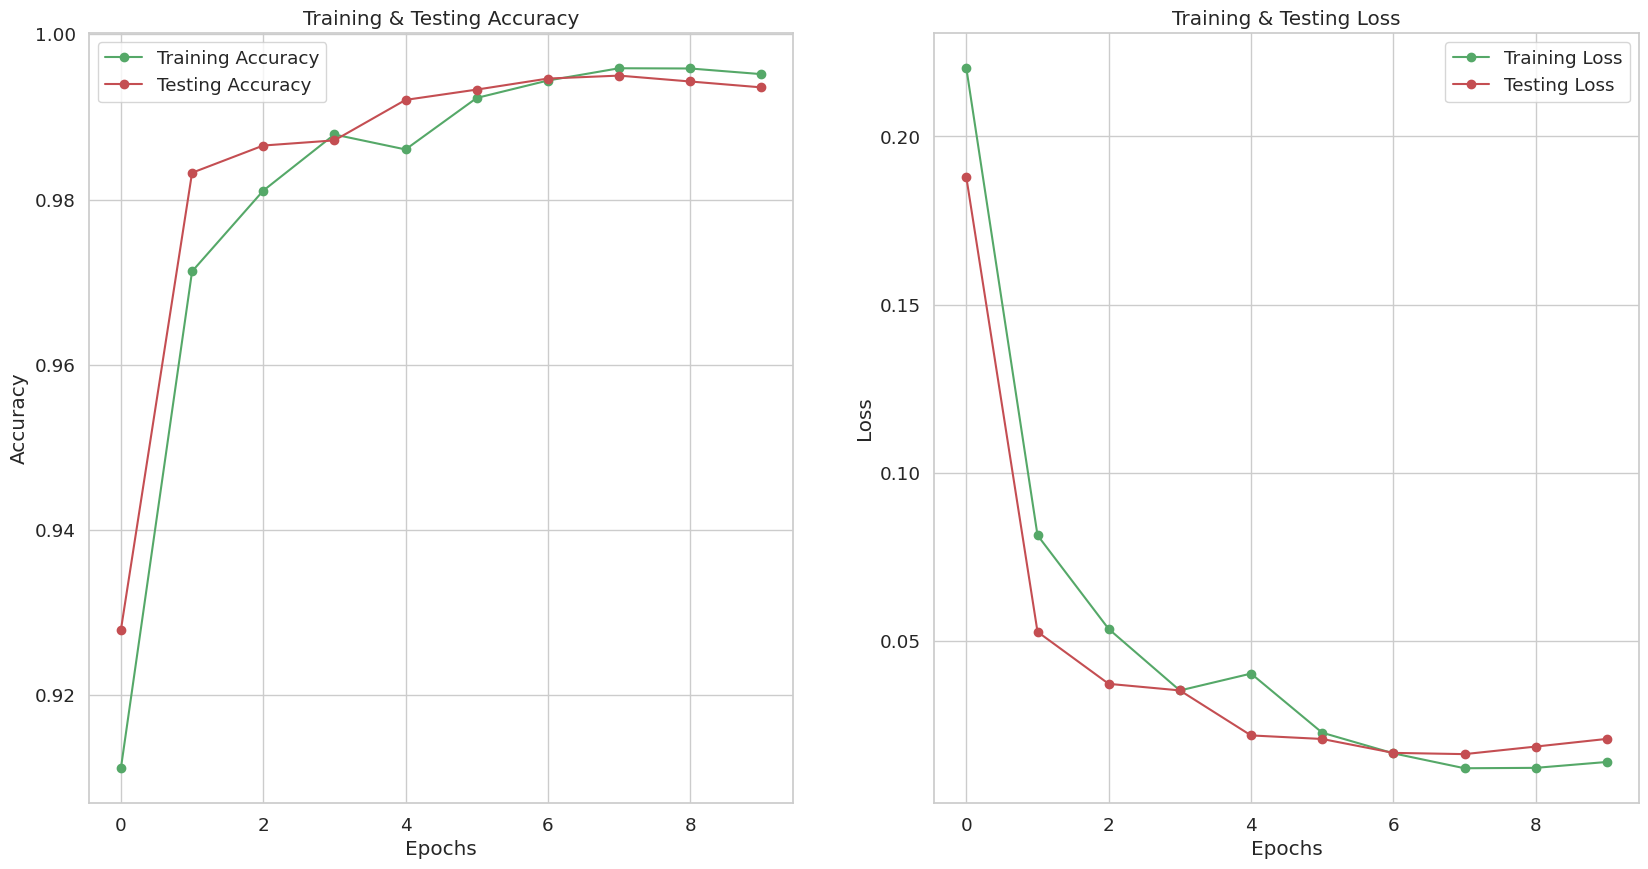

In [ ]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
pred = model.predict(X_test)
pred[:5]

351/351 [==============================] - 54s 150ms/step


array([[5.5359101e-06],
       [8.6464490e-07],
       [4.8567649e-06],
       [6.2435261e-06],
       [9.9999845e-01]], dtype=float32)

In [ ]:
pred_conver = pred.round()

In [ ]:
y_test[:5]

13888    0
7763     0
8388     0
16820    0
5099     1
Name: category, dtype: int64

In [ ]:
# Macierz konfuzji
from sklearn.metrics import classification_report,confusion_matrix
conf_test=confusion_matrix(y_test, pred_conver)

print(conf_test)

[[5799   59]
 [  13 5354]]


In [ ]:
print(classification_report(y_test, pred_conver, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       1.00      0.99      0.99      5858
    Not Fake       0.99      1.00      0.99      5367

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [ ]:
cm = pd.DataFrame(conf_test , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(88.25, 0.5, 'Actual')

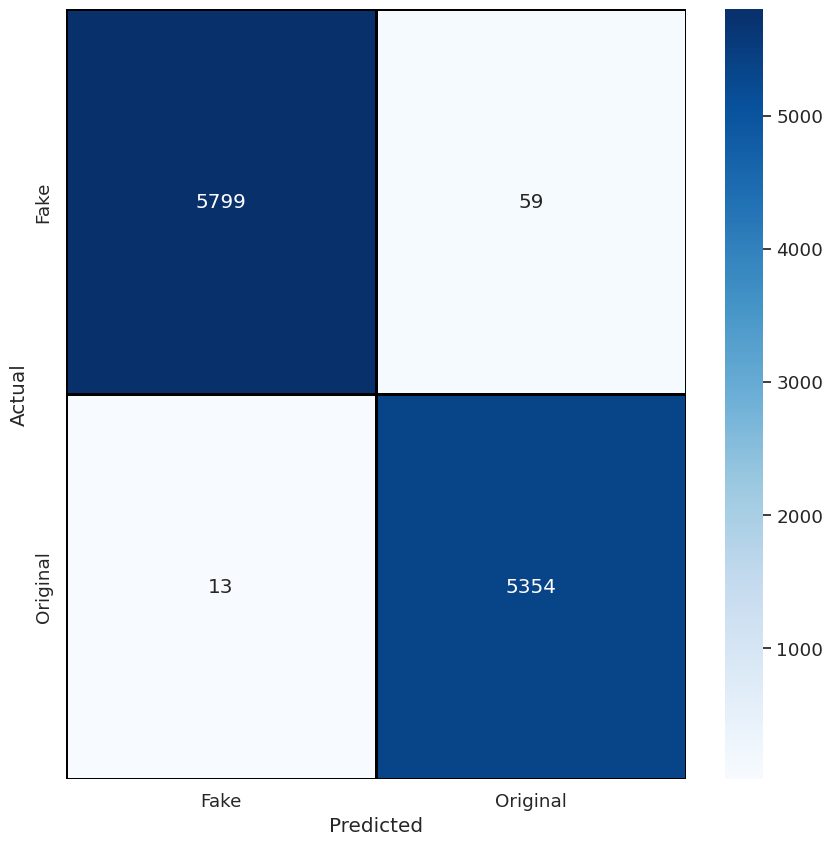

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")